# KNN Classification of Weather

## Table of Contents:
* [Introduction](#intro)
* [Exploring the Dataset](#explore)
    * [Tidying the Data](#tidy)
    * [Visualization](#viz)
* [Data Analysis](#analysis)
    * [Method Overview](#overview)
    * [Forward Selection](#fs)
    * [Model Training](#training)
    * [Predictions and Model Accuracy](#accuracy)
    * [Model Visualization](#model-viz)
* [Discussion](#discussion)
* [References](#ref)

## Introduction <a class="anchor" id="intro"></a>

Weather warnings are important forecasts because they are used to protect life and property. Especially in Seattle, a city that rains often, forecasts are made based on temperature, precipitation to help determine future climate expectations. These forecasts help improve business outcomes such as in inventory planning and production strategy and help farmers plan for power usage, irrigation and protection (Michigan Technological University, 2020). Weather data can also help people plan activities and dress for the weather accordingly.
 
This model aims to answer the question: **how well can we classify weather using precipitation, temperature, and wind speed data**? The data set we obtained (source: https://www.kaggle.com/ananthr1/weather-prediction) contains daily observations of weather in Seattle, Washington between 2012 to 2015. The set of variables per observation in this data set is:
- date: the date of the observation
- precipitation: the amount of precipitation in any form (cm)
- temp_max: the maximum temperature (Celsius)
- temp_min: the minimum temperature (Celsius)
- wind: the wind speed (mph)
- weather: the type of weather (drizzle, rain, sun, snow, fog)

By understanding the relationships among these variables, it helps meteorologists better predict the weather for the public. Note that the original data set did not provide units, so we made a reasonable guess for each variable. (For example, 10°C is more reasonable than 10°F for temperature)

We use the **k-nearest neighbors** algorithm here because "type of weather" is a categorical variable. We will discuss pros and cons of this algorithm in the discussion section.

## Exploring the Dataset <a class="anchor" id="explore"></a>

In [1]:
# Run this code to set up the notebook
library(tidyverse)
library(repr)
library(tidymodels)
require("devtools")
install.packages("themis")
library("themis")
options(repr.matrix.max.rows = 6)
install.packages("knitr")
library(knitr)
library(cowplot)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘ellipsis::check_dots_unnamed’ by ‘rlang::check_dots_unnamed’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘ellipsis::check_dots_used’ by ‘rlang::check_dots_used’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘ellipsis::check_dots_empty’ by ‘rlang::check_dots_empty’ when loading ‘tibble’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Co

In [6]:
# Read the data into R (provided by https://www.kaggle.com/ananthr1/weather-prediction)
weather <- read_csv("https://raw.githubusercontent.com/irisxu02/dsci100-group13/main/weather.csv")
weather

Parsed with column specification:
cols(
  date = col_date(format = ""),
  precipitation = col_double(),
  temp_max = col_double(),
  temp_min = col_double(),
  wind = col_double(),
  weather = col_character()
)



date,precipitation,temp_max,temp_min,wind,weather
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-02,10.9,10.6,2.8,4.5,rain
2012-01-03,0.8,11.7,7.2,2.3,rain
⋮,⋮,⋮,⋮,⋮,⋮
2015-12-29,0,7.2,0.6,2.6,fog
2015-12-30,0,5.6,-1.0,3.4,sun
2015-12-31,0,5.6,-2.1,3.5,sun


### Tidying the Data <a class="anchor" id="tidy"></a>

We want the weather variable to be categorical, so we need to convert it to type factor. Furthermore, we want to create a new variable for average temperature because that would enhance the data set by giving us a new and simpler way to look at temperature. We do this below.

In [8]:
weather_data <- weather %>%
    mutate(weather = as_factor(weather),
           temp_avg = (temp_max + temp_min)/2)
weather_data

date,precipitation,temp_max,temp_min,wind,weather,temp_avg
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
2012-01-01,0.0,12.8,5.0,4.7,drizzle,8.90
2012-01-02,10.9,10.6,2.8,4.5,rain,6.70
2012-01-03,0.8,11.7,7.2,2.3,rain,9.45
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2015-12-29,0,7.2,0.6,2.6,fog,3.90
2015-12-30,0,5.6,-1.0,3.4,sun,2.30
2015-12-31,0,5.6,-2.1,3.5,sun,1.75


Now that we have tidy data, we would like to perform a summary to see how many observations of each type of weather we have. Is our data evenly distributed? 

In [3]:
# Count the number of observations for each weather type
weather_data_count <- weather_data %>%
    group_by(weather) %>%
    summarize(n = n())
kable(weather_data_count, caption = "The number of observations recorded for each type of weather")

`summarise()` ungrouping output (override with `.groups` argument)




Table: The number of observations recorded for each type of weather

|weather |   n|
|:-------|---:|
|drizzle |  53|
|rain    | 641|
|sun     | 640|
|snow    |  26|
|fog     | 101|

Our data is highly unbalanced with respect to our target variable. For this reason, we will upsample the rare weather in our data analysis.

### Visualization <a class="anchor" id="viz"></a>

We want to provide a plot of the data so we can get a visual overview of what we are working with.

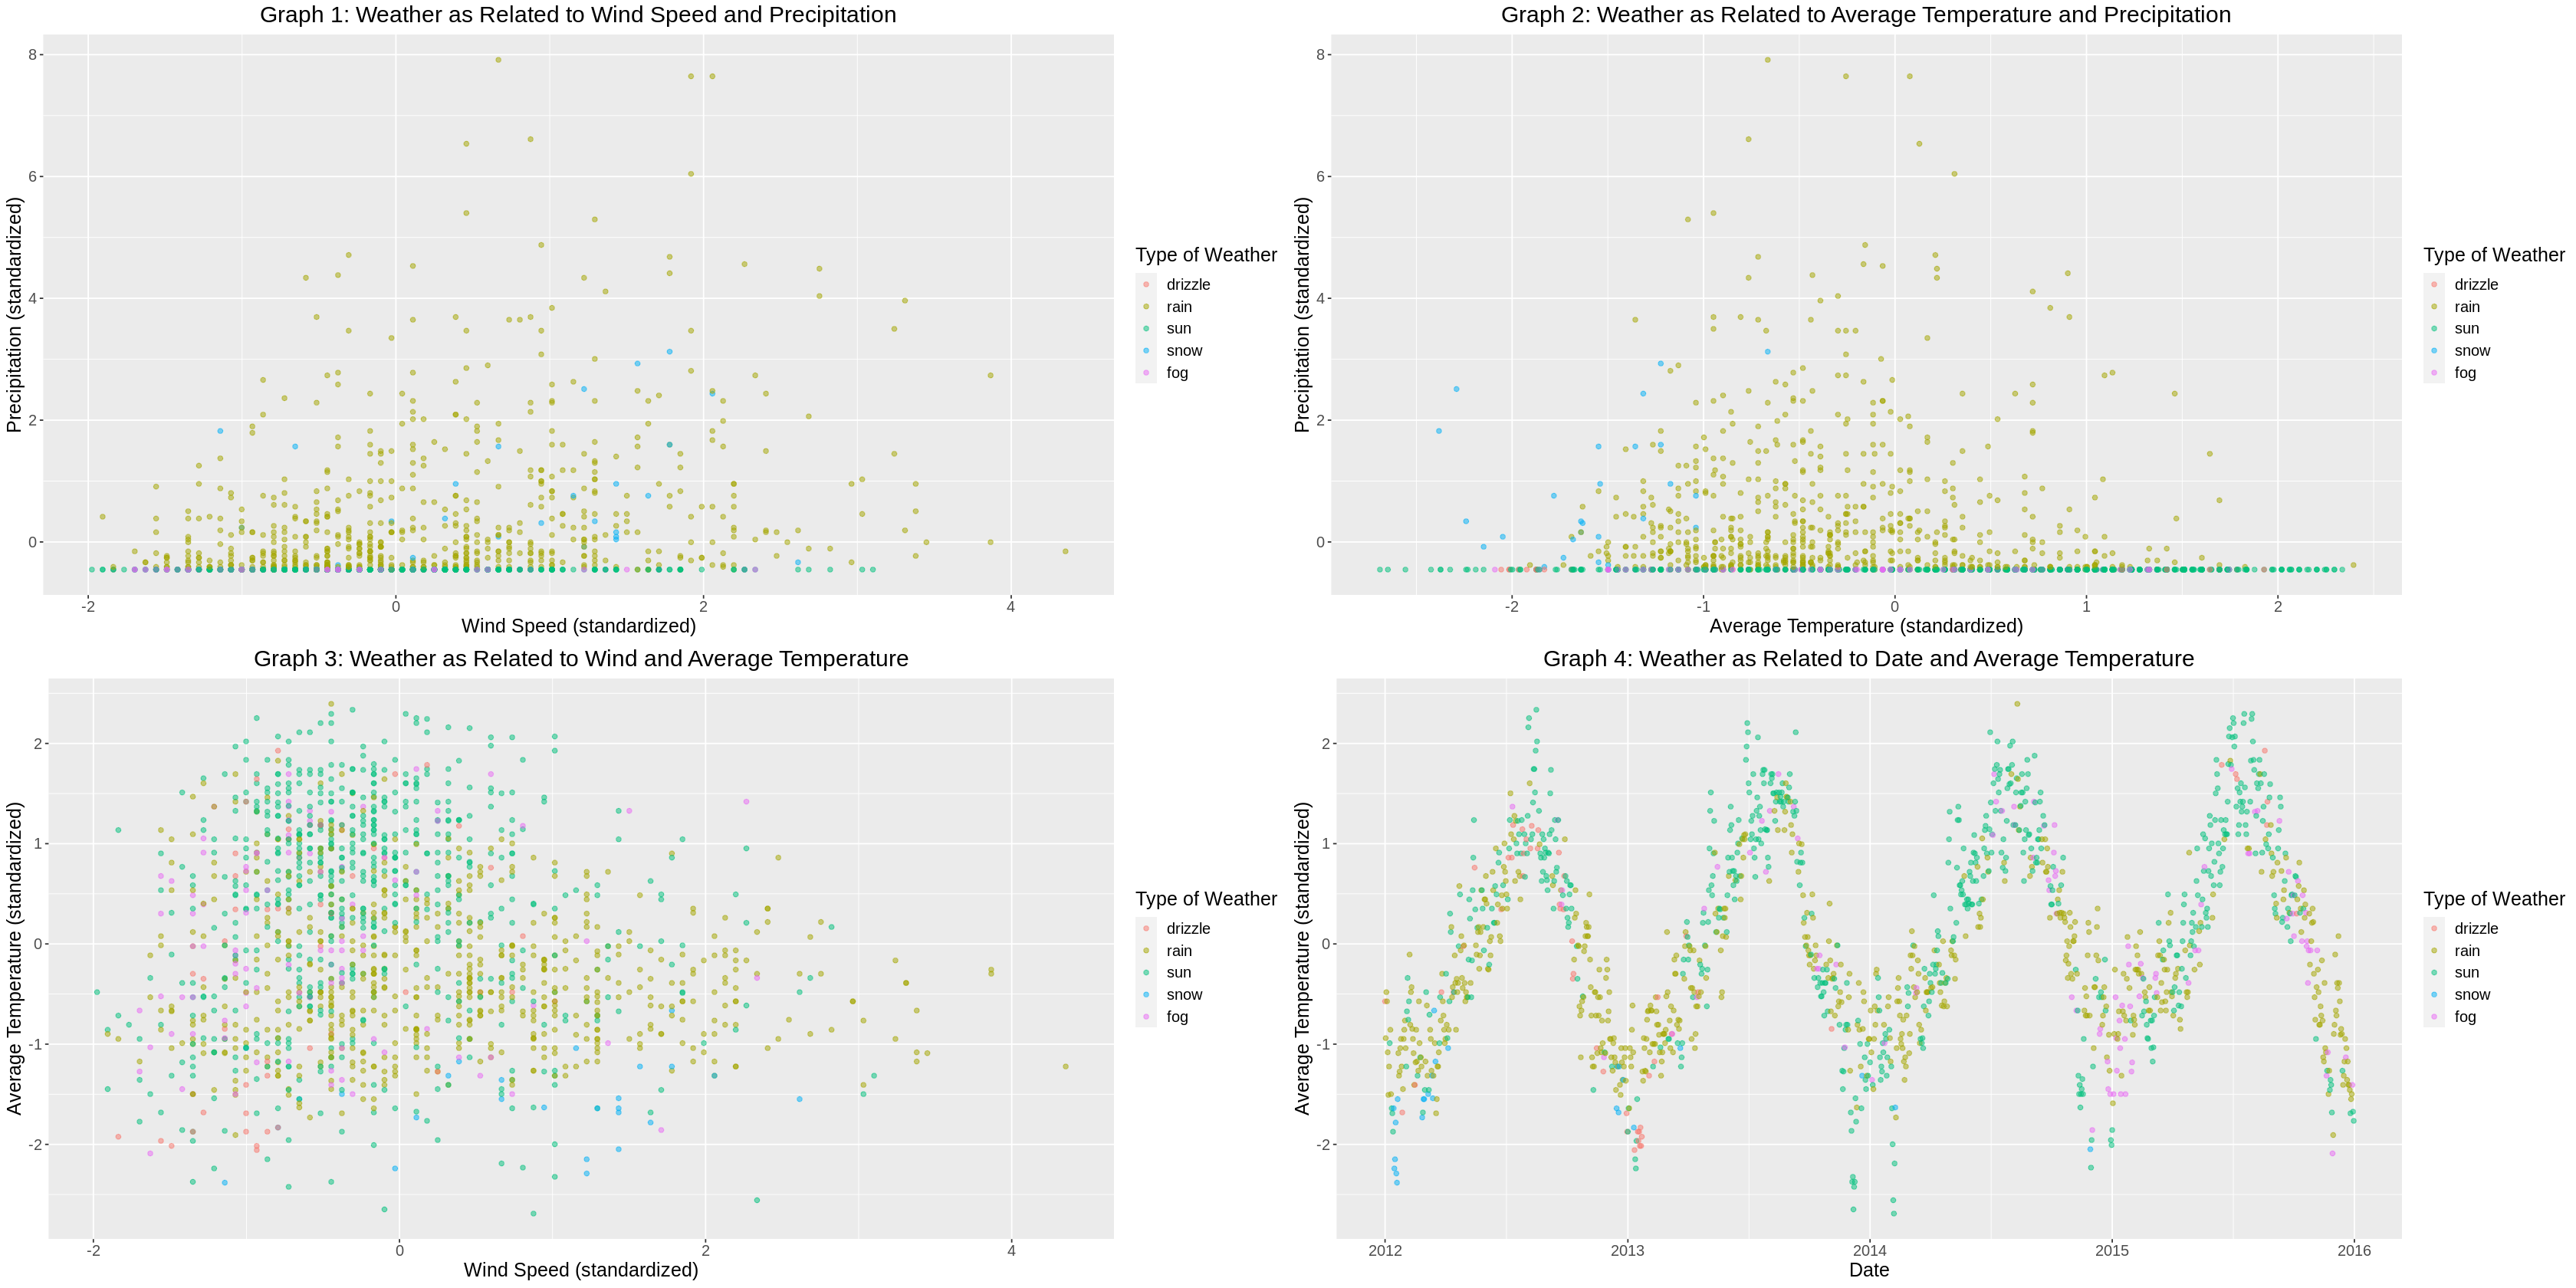

In [51]:
options(repr.plot.width = 28, repr.plot.height = 14)
# Scale the weather data
weather_data_scaled <- weather_data %>%
    mutate(scaled_precipitation = scale(precipitation, center = TRUE),
          scaled_wind = scale(wind, center = TRUE),
          scaled_temp_avg = scale(temp_avg, center = TRUE))
# Create scatterplots using ggplot to visualize the data
wind_prec_plot <- weather_data_scaled %>% 
    ggplot(aes(x = scaled_wind, y = scaled_precipitation)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Graph 1: Weather as Related to Wind Speed and Precipitation", color = "Type of Weather") +
    xlab("Wind Speed (standardized)") +
    ylab("Precipitation (standardized)") +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
temp_prec_plot <- weather_data_scaled %>% 
    ggplot(aes(x = scaled_temp_avg, y = scaled_precipitation)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Graph 2: Weather as Related to Average Temperature and Precipitation", color = "Type of Weather") +
    xlab("Average Temperature (standardized)") +
    ylab("Precipitation (standardized)") +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
wind_temp_plot <- weather_data_scaled %>% 
    ggplot(aes(x = scaled_wind, y = scaled_temp_avg)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Graph 3: Weather as Related to Wind and Average Temperature", color = "Type of Weather") +
    xlab("Wind Speed (standardized)") +
    ylab("Average Temperature (standardized)") +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
date_temp_plot <- weather_data_scaled %>% 
    ggplot(aes(x = date, y = scaled_temp_avg)) +
    geom_point(aes(color = weather), alpha = 0.5) +
    labs(title = "Graph 4: Weather as Related to Date and Average Temperature", color = "Type of Weather") +
    xlab("Date") +
    ylab("Average Temperature (standardized)") +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
# show the scatterplots side by side
plot_grid(wind_prec_plot, temp_prec_plot, wind_temp_plot, date_temp_plot, nrow = 2)

In graph 1 and 2, we can see that wind speed and average temperature are positively correlated to precipitation. Putting the two variables together in graph 3, we get sunny days when temperature is high and wind speed is low and rainy days when temperature is low regardless of the wind speed. This shows us that temperature is a stronger predictor of weather than wind speed. In other words, rainy days tend to happen when temperature drops and vice versa for sunny days. Follwing that, graph 4 demonstrates the seasonal variation where the temperature goes up and down, transitioning from summer days to rain season. This trend is typical of a temperate occeanic climate with fairly sunny summers and mild, rainy winters. In order to generate a model to predict weather worldwide, we decided to disreagrd date, though as a good predictor, specific to Seattle and instead chose minimum temperature, precipitation, and average temperature as predictors to train our model. In this way, our model is widely applicable.

## Data Analysis <a class="anchor" id="analysis"></a>

### Method Overview <a class="anchor" id="overview"></a>

1. Perform forward selection to get a better understanding of which variables do better as predictors in the following steps
2. Split the data into training and testing sets with a 75%/25% train/test proportion
3. Perform 5-fold cross-validation to find the best K value for our K-nearest neighbours model
    - Create a `nearest_neighbor` model specification with `neighbors = tune()`
    - Create a `recipe` with steps for upsampling to fix imbalance, center and scaling to standardize
    - Test K values from 1 through 10
4. Train and fit the final model
    - Create a new model specification using the best K value
    - Retrain the classifier using the `fit` function
5. Make predictions on the testing data set
6. Calculate the accuracy of our predictions and evaluate our model based on this accuracy
    - Produce a confusion matrix to see the breakdown of how our model has been classifying observations
7. Visualize our final model

### Forward Selection <a class="anchor" id="fs"></a>

We want to know which variables to use as predictors in our data analysis. Here, we perform forward selection to select the most relevant predictors. We do not include date in our potential set of predictors because although it gives us a good idea what weather we should expect based on what season it is, it is not directly related to weather and definitely does not influence the type of weather we observe. We want our model to be generalizable to other locations, and seasonal trends could be very different based on location, so in the following step we test precipitation, temperature and wind variables to see which combination might give us the highest predictive accuracy.

In [5]:
# create a list consisting of variables we want to test
var_names <- list("precipitation", "temp_avg", "temp_max", "temp_min", "wind")
var_names

[[1]]
[1] "precipitation"

[[2]]
[1] "temp_avg"

[[3]]
[1] "temp_max"

[[4]]
[1] "temp_min"

[[5]]
[1] "wind"

In [6]:
# Set seed to 123 (do not change)
set.seed(123)
# create an empty tibble to store the results
fs_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
fs_weather_vfold <- vfold_cv(weather_data, v = 5, strata = weather)

# store the total number of predictors
n_total <- length(var_names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(var_names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, var_names[[j]])
        model_string <- paste("weather", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        weather_recipe <- recipe(as.formula(model_string), data = weather_data) %>%
                          step_upsample(weather, over_ratio = 1)
                          step_scale(list(var_names)) %>%
                          step_center(list(var_names))

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(weather_recipe) %>%
          add_model(knn_tune) %>%
          tune_grid(resamples = fs_weather_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    fs_accuracies <- fs_accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, var_names[[jstar]])
    var_names <- var_names[-jstar]
}
fs_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,weather ~ precipitation,0.4400995
2,weather ~ precipitation+temp_avg,0.6700562
3,weather ~ precipitation+temp_avg+temp_min,0.6905903
4,weather ~ precipitation+temp_avg+temp_min+temp_max,0.6782332
5,weather ~ precipitation+temp_avg+temp_min+temp_max+wind,0.6652968


In [7]:
kable(fs_accuracies, caption = "Potential sets of predictor variables and prediction accuracy")



Table: Potential sets of predictor variables and prediction accuracy

| size|model_string                                            |  accuracy|
|----:|:-------------------------------------------------------|---------:|
|    1|weather ~ precipitation                                 | 0.4400995|
|    2|weather ~ precipitation+temp_avg                        | 0.6700562|
|    3|weather ~ precipitation+temp_avg+temp_min               | 0.6905903|
|    4|weather ~ precipitation+temp_avg+temp_min+temp_max      | 0.6782332|
|    5|weather ~ precipitation+temp_avg+temp_min+temp_max+wind | 0.6652968|

The table above shows that out of the 5 sets of predictors being tested, the one using precipitation+temp_avg+temp_min gives the best accuracy. There is a significant improvement when temp_avg is used as a predictor in addition to precipitation, and a relatively smaller improvement when adding temp_min as the third predictor variable. Overall, we see that more predictors doesn't necessarily lead to a better model. When both temp_max and wind variables are added, the accuracy level drops, perhaps because the additional predictors adds an unnecessary layer of complication and makes the model concerned with irrelevant/less relevant variables.

Forward selection in this way doesn't test all of the possible combinations of variables we could be using as predictors, and the process is time consuming. There could be better ways of selecting variables. However, by combining intuition and this technique to produce accuracy estimates for a few possible combinations, we can optimize our model accuracy to an extent that is enough for our purposes in this assignment.

In the following section where we train our model, we will use 3 predictors: **precipitation, average temperature, minimum temperature**.

### Model Training <a class="anchor" id="training"></a>

In [14]:
# Set seed to 100 (do not change)
set.seed(100)
# split the data set into training and testing sets
weather_split <- initial_split(weather_data, prop = 0.75, strata = weather)
weather_train <- training(weather_split)
weather_test <- testing(weather_split)

# create a nearest neighbor model with neighbors set to tune for this step
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# create a recipe with upsample, scale, and center
weather_recipe <- recipe(weather ~ precipitation + temp_avg + temp_min, data = weather_train) %>%
    step_upsample(weather, over_ratio = 1, skip = FALSE) %>%
    prep()
weather_bake <- bake(weather_recipe, weather_train)
weather_recipe <- recipe(weather ~ precipitation + temp_avg + temp_min, data = weather_bake) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# perform cross validation to find optimal k
weather_vfold <- vfold_cv(weather_train, v = 5, strata = weather)
knn_results <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(knn_tune)  %>%
    tune_grid(resamples = weather_vfold, grid = tibble(neighbors = seq(1, 10))) %>%
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7047011,5,0.01196716,Model01
1,roc_auc,hand_till,0.6360250,5,0.01494736,Model01
2,accuracy,multiclass,0.7028579,5,0.01274106,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.7412943,5,0.008402493,Model09
10,accuracy,multiclass,0.7658267,5,0.015819644,Model10
10,roc_auc,hand_till,0.7553546,5,0.012437464,Model10


Above we have the results of our cross validation step, but we only really care about the mean accuracy for the different number of neighbors 1 through 10. We can filter and select those variables/values from the tibble and show the results in a table. We decided to upsample in a separate recipe as it failed doing it in the same receipe along with centering. This is the best alternative to ensure that the sub-datasets in v-fold are relatively proportional in terms of classes. However, we cannot be entirely sure if the function has indeed applied to v-fold by having two recipes.

In [15]:
# filter for accuracies
accuracies <- knn_results %>% filter(.metric == "accuracy") %>% select(neighbors, mean)
kable(accuracies, caption = "KNN Classification weather prediction accuracy estimates for different numbers of neighbors")



Table: KNN Classification weather prediction accuracy estimates for different numbers of neighbors

| neighbors|      mean|
|---------:|---------:|
|         1| 0.7047011|
|         2| 0.7028579|
|         3| 0.7466567|
|         4| 0.7585623|
|         5| 0.7639793|
|         6| 0.7658141|
|         7| 0.7612521|
|         8| 0.7658183|
|         9| 0.7649009|
|        10| 0.7658267|

However, it is difficult to read a table at first glance. Instead, we visualize the prediction accuracies with respect to the number of neighbors below for a more intuitive picture.

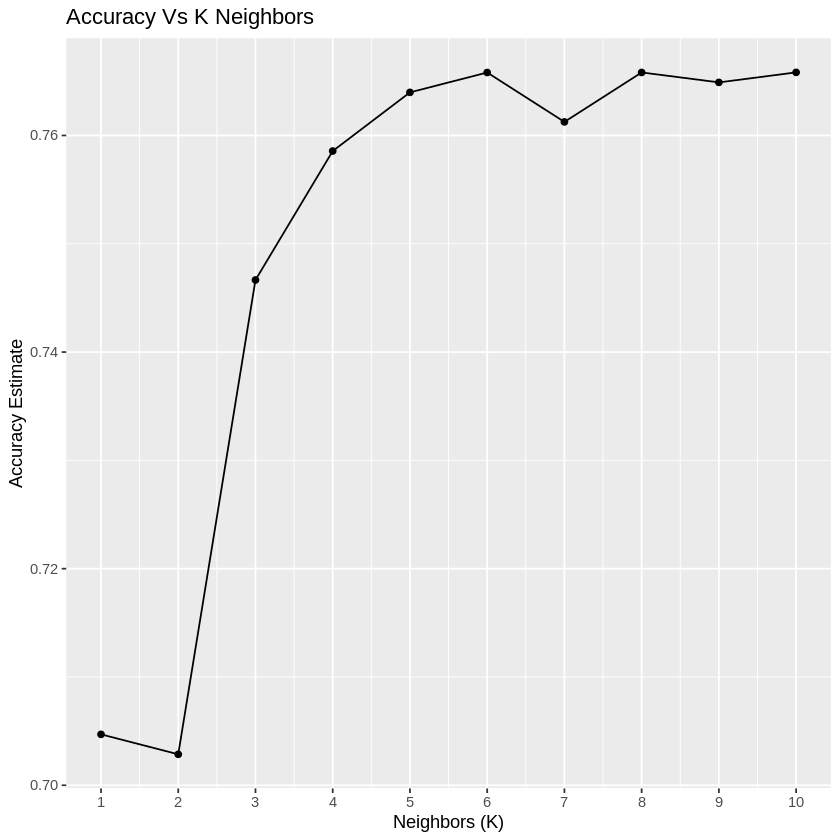

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)

# plot to visualize accuracies vs number of neighbors (k)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (K)", y = "Accuracy Estimate") +
       ggtitle("Accuracy Vs K Neighbors") +
       scale_x_continuous(breaks = seq(0, 10, by = 1))  # adjusting the x-axis

accuracy_versus_k

It appears that the accuracy of the model keeps improving when $k$ increases, $k\ge2$. However we notice that with $k$ greater than 5, the accuracy only improves minimally. Moreover, we keep in mind that KNN algorithm slows with higher k values, we choose to take $k=5$. This is the number of neighbors for the KNN classification model that would give us a relatively high prediction accuracy while not slowing the algorithm too much, so we use it in creating our final model below.

In [17]:
# select best k
best_k <- 5
# create new model and set neighbors to best k value found through cross validation
weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")
weather_fit <- workflow() %>%
       add_recipe(weather_recipe) %>%
       add_model(weather_spec) %>%
       fit(data = weather_train)
weather_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~best_k,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2242479
Best kernel: rectangular
Best k: 5

### Predictions and Model Accuracy <a class="anchor" id="accuracy"></a>

At this point, we are ready to use our model on our testing data set to make some predictions!

In [18]:
weather_predictions <- predict(weather_fit, weather_test)  %>%
    bind_cols(weather_test)
weather_predictions
weather_metrics <- weather_predictions %>%
    metrics(truth = weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
weather_metrics

.pred_class,date,precipitation,temp_max,temp_min,wind,weather,temp_avg
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
rain,2012-01-01,0.0,12.8,5.0,4.7,drizzle,8.90
rain,2012-01-02,10.9,10.6,2.8,4.5,rain,6.70
rain,2012-01-03,0.8,11.7,7.2,2.3,rain,9.45
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
rain,2015-12-28,1.5,5.0,1.7,1.3,rain,3.35
sun,2015-12-30,0.0,5.6,-1.0,3.4,sun,2.30
sun,2015-12-31,0.0,5.6,-2.1,3.5,sun,1.75


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7582418


We see that the accuracy of our model is approximately 75.8%.

In [36]:
weather_conf_mat <- weather_predictions %>%
    conf_mat(truth = weather, estimate = .pred_class) %>%
    print()
cm_df <- data.frame(weather_conf_mat)
kable(cm_df, caption = "Confusion matrix as a table")

          Truth
Prediction drizzle rain sun snow fog
   drizzle       3    0   0    0   0
   rain          3  131  10    3   1
   sun           7   25 141    2  21
   snow          0    0   0    1   0
   fog           2    2  12    0   0




Table: Confusion matrix as a table

|Prediction |Truth   | Freq|
|:----------|:-------|----:|
|drizzle    |drizzle |    3|
|rain       |drizzle |    3|
|sun        |drizzle |    7|
|snow       |drizzle |    0|
|fog        |drizzle |    2|
|drizzle    |rain    |    0|
|rain       |rain    |  131|
|sun        |rain    |   25|
|snow       |rain    |    0|
|fog        |rain    |    2|
|drizzle    |sun     |    0|
|rain       |sun     |   10|
|sun        |sun     |  141|
|snow       |sun     |    0|
|fog        |sun     |   12|
|drizzle    |snow    |    0|
|rain       |snow    |    3|
|sun        |snow    |    2|
|snow       |snow    |    1|
|fog        |snow    |    0|
|drizzle    |fog     |    0|
|rain       |fog     |    1|
|sun        |fog     |   21|
|snow       |fog     |    0|
|fog        |fog     |    0|

This is the complete table for the confusion matrix showing all the predictions made by our classifier versus the true weather classifications.

### Model Visualization <a class="anchor" id="model-viz"></a>

In [39]:
all_percents <- cm_df %>% group_by(Truth) %>% mutate(percent = Freq/sum(Freq) * 100)
all_percents

kable(all_percents, caption = "Table of Percentage of Predictions Against The Truth")

Prediction,Truth,Freq,percent
<fct>,<fct>,<int>,<dbl>
drizzle,drizzle,3,20.00000
rain,drizzle,3,20.00000
sun,drizzle,7,46.66667
⋮,⋮,⋮,⋮
sun,fog,21,95.45455
snow,fog,0,0.00000
fog,fog,0,0.00000




Table: Table of Percentage of Predictions Against The Truth

|Prediction |Truth   | Freq|   percent|
|:----------|:-------|----:|---------:|
|drizzle    |drizzle |    3| 20.000000|
|rain       |drizzle |    3| 20.000000|
|sun        |drizzle |    7| 46.666667|
|snow       |drizzle |    0|  0.000000|
|fog        |drizzle |    2| 13.333333|
|drizzle    |rain    |    0|  0.000000|
|rain       |rain    |  131| 82.911392|
|sun        |rain    |   25| 15.822785|
|snow       |rain    |    0|  0.000000|
|fog        |rain    |    2|  1.265823|
|drizzle    |sun     |    0|  0.000000|
|rain       |sun     |   10|  6.134969|
|sun        |sun     |  141| 86.503068|
|snow       |sun     |    0|  0.000000|
|fog        |sun     |   12|  7.361963|
|drizzle    |snow    |    0|  0.000000|
|rain       |snow    |    3| 50.000000|
|sun        |snow    |    2| 33.333333|
|snow       |snow    |    1| 16.666667|
|fog        |snow    |    0|  0.000000|
|drizzle    |fog     |    0|  0.000000|
|rain       |fog 

Here, we made a data frame comparing how many predictions our classifer made for each weather type versus the total number of the predictions made for that true weather type. For instance, out of all the predictions that should have been drizzle, 20.0% of the predictions were predicted drizzle correctly. We chose to do this step before graphing our results because we do not just want the number of predictions made for the specific weathers (the Freq column). Percentages allow for a cleaner and more efficient way to draw conclusions. Also, since we wanted to compare the percentages of predictions made against the specific weathers (drizzle, rain, sun, snow, & fog), we found the percentages and use them in the plot below.

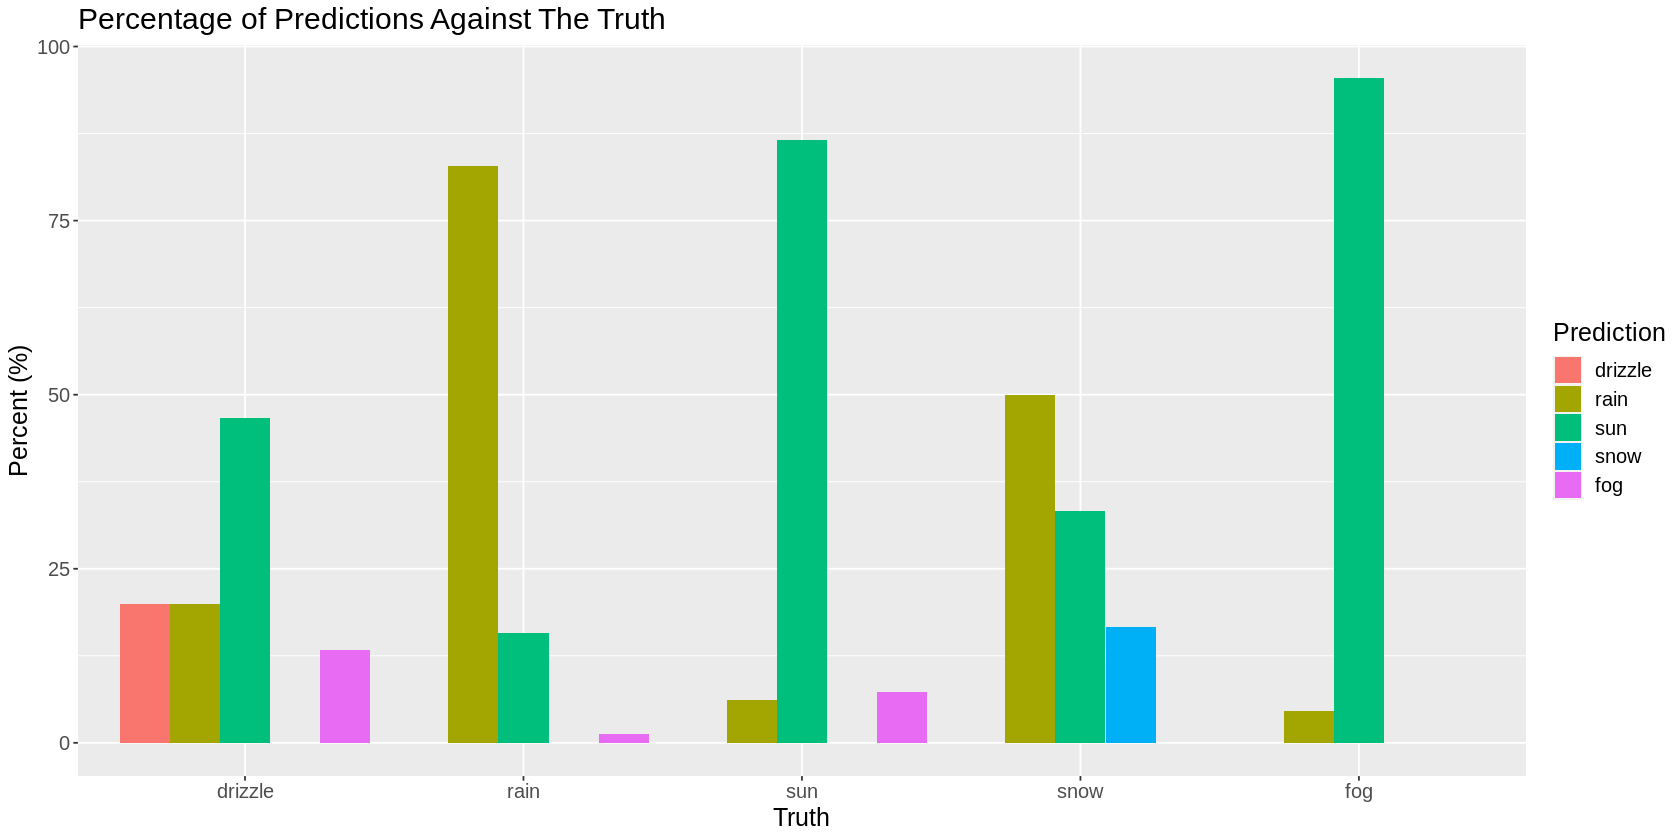

In [50]:
options(repr.plot.width = 14, repr.plot.height = 7)

top_n_state_plot <- all_percents %>%
    ggplot(aes(x = Truth, y = percent, fill = Prediction)) + 
    geom_bar(stat = "identity", position = "dodge") + 
    xlab("Truth") +
    ylab("Percent (%)") +
    labs(fill = "Prediction") +
    ggtitle("Percentage of Predictions Against The Truth") +
    theme(text = element_text(size = 15))
top_n_state_plot

We chose to plot our graph this certain way because it shows a clean representation of the predictions made versus what the prediction should have been. The x-axis shows the true weather types and the y-axis is the percentage of predictions it made in comparison to that true weather type. The colors correspond to what the classifer predicted for each of the true weather classifications. This graph clearly allows the oberver to compare the prediction our classifer made instead of what it should have been as well as the percentages of the correct predictions. Just looking at the graph, there seems to be a lot of sun predictions for what should have been drizzle and fog and a bit of rain for what should have been snow. However, the classifier did predict quite a bit of the rain and sun weathers, but not as much for drizzle, snow, or fog.

## Discussion <a class="anchor" id="discussion"></a>

**Summarize what you found.** Our original question is **how well can we classify weather using precipitation, temperature, and wind speed data?** Through our analysis, we found that wind is not a strong predictor as minimum temperature and we exluded date to make our model more generalizable. Hence, using **precipitation, average temperature, and minimum temperature** as predictors in our final $K=5$ classification model, we have achieved an overall accuracy of **75.8%**. Our model predicts with ~83% accuracy for rain, ~87% for sun, 20% for drizzle and ~17% for snow. However we do not know the prediction accuracy for fog since our testing set doesn't have an observation for foggy weather. (see table of percentages)

**Discuss whether this is what you expected to find?** This model is fairly accurate at predicting rain and sun with an average 85% accuracy. However, the model is not doing so well with drizzle and fog. And it’s not surprising that the model is not sensitive enough to differentiate drizzle from rain given the similarities in conditions. On the other hand, the model fails to predict snow due to limited available data.

**Discuss what impact could such findings have?** The goal of weather prediction is to provide information people and organizations can use to mitigate weather-related losses, help protect life and property and ensure public health and safety (National Research Council, 2010). Especially in the time of global warming, this model is becoming more important as a tool to detect usual weather patterns and use historical data to inform climate change decisions.

**Discuss what future questions could this lead to?** For further questions, how can we leverage our knowledge of seasonal changes but still make the model generalizable? One could hope that future models are capable of incorporating our knowledge of seasonal changes and locational variations to make more generalizable and accurate predictions.

We could also look at improving our model. With the data available, we can further try different combinations of variables in our forward selection step to select a better set of variables with more predictive power. But are there other variables which we can interpret that do well at predicting the type of weather? For example, we are curious as to whether temperature difference (temp_max - temp_min) would be a good predictor and if it can improve our prediction accuracy. There are likely many variables that aren't even included in this data set that data scientists use for applications in meteorology and studies surrounding weather and climate change.

**KNN Pros and Cons** KNN is a intuitive and simple algorithm that helped us classify a categorical variable. Some weaknesses of this algorithm are that it can become slow on larger training data sets, and that it doesn't predict well when classes are unbalanced (which is why we had to upsample).

## References <a class="anchor" id="ref"></a>

R, A. (2022, January 17). Weather Prediction. Kaggle. Retrieved March 11, 2022, from https://www.kaggle.com/ananthr1/weather-prediction

April 30, 2020. (n.d.). Weather and applied statistics. Michigan Technological University. Retrieved April 5, 2022, from https://onlinedegrees.mtu.edu/news/weather-applied-statistics

Division on Earth and Life Studies, National Research Council, Board on Atmospheric Sciences and Climate, & Committee on Progress and Priorities of U.S. Weather Research and Research-to-Operations Activities. (2010). When weather matters: Science and services to meet critical societal needs. National Academies Press. https://doi.org/10.17226/12888